## Advanced Lane Finding Project

**Primary goals:**

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

**Additional goals:**

* Quantify lane detection performance 
* Use the lane detection performance metric as a cost function to tune various threasholds
* Run DOEs to tune various threasholds

## Camera calibration

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output objpoints and imgpoints to compute the camera calibration and distortion coefficients using the cv2.calibrateCamera() function. 

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
%matplotlib inline

global total_frames_captured 
global total_frames_missed 
global total_frames_brute_force 
global grad_low
global grad_low
global hls_binary_low
global hls_binary_high
global n_smooth

n_frame_missed = 0
max_frame_missed = 4 
total_frames_captured = 0
total_frames_missed = 0
total_frames_brute_force = 0 
n_smooth = 5


In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        if False:
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(1000)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
#print(ret, '\n', mtx, '\n', dist, '\n', rvecs , '\n',tvecs,'\n')

## Distortion correction

Once the camera distortion correction coefficients have been obtained they are then applied to correct an image using cv2.undistort() 

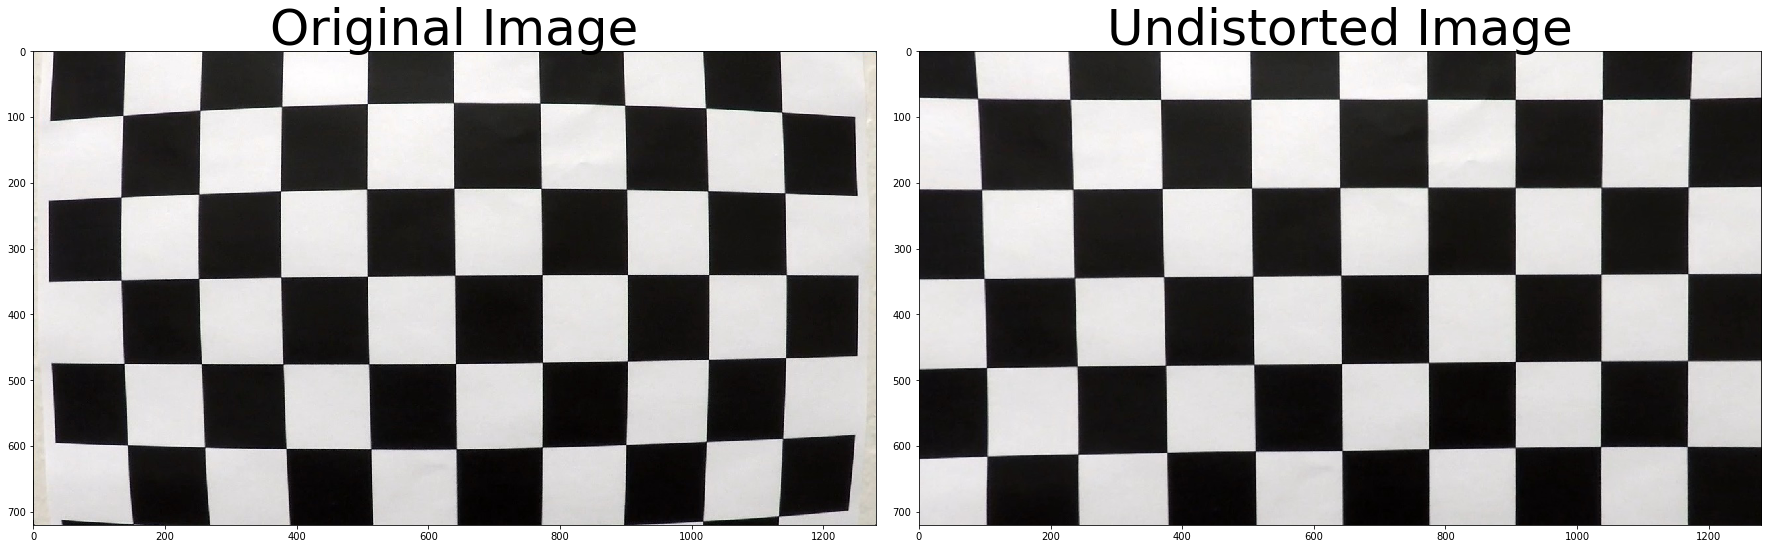

In [3]:
def cal_undistort(img, mtx, dist):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

img = mpimg.imread('../camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color Threshold
Only the S channel was used since it was found to be the most promising channel.  However, the R channel could also be used since it can capture the white lines better than the S channel.   

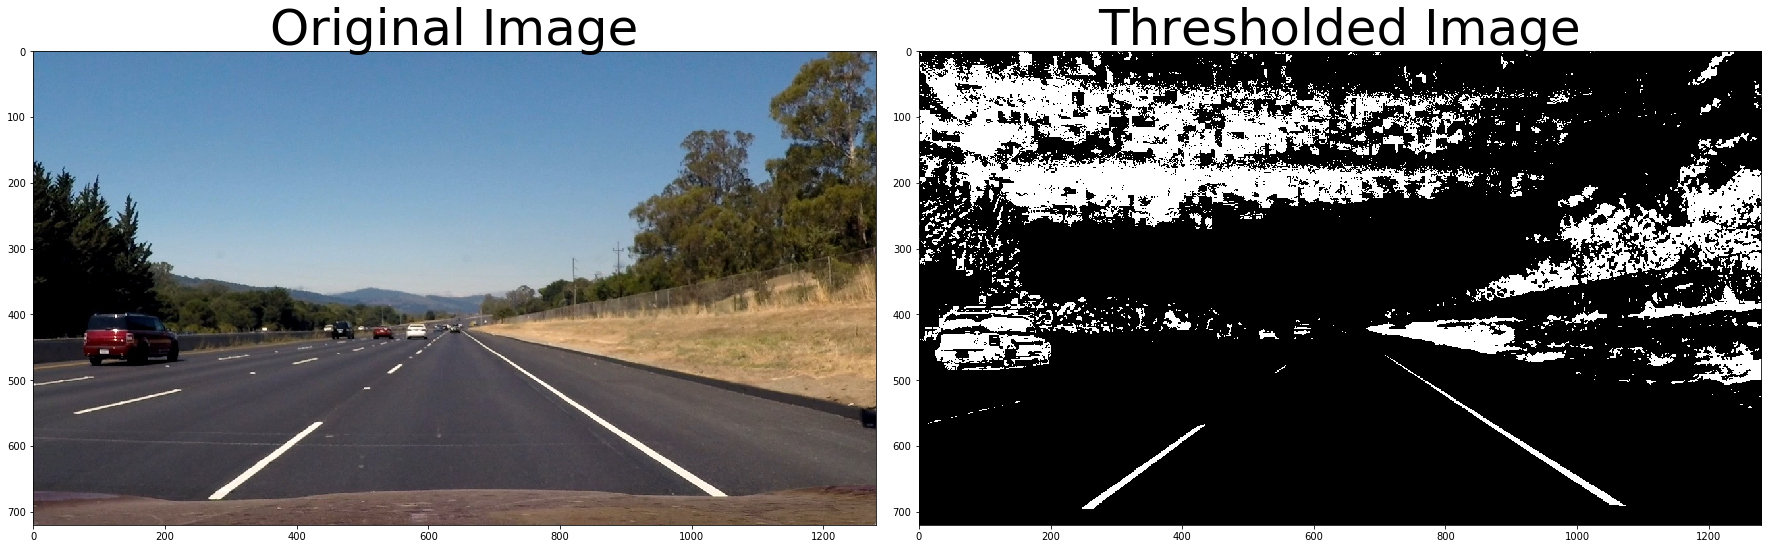

In [4]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S<= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

img = mpimg.imread('../test_images/straight_lines2.jpg')
undistorted = cal_undistort(img, mtx, dist)
thresh = (100, 255)
color_thresholded = hls_select(undistorted, thresh)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(color_thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Gradient Threshold

The following gradient operators were applied on the image 
* Sobel Operator in X and Y
* Magnitude Gradient
* Direction of Gradient

In [5]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient =='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    # 2) Take the gradient in x and y separately
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel))  
    # 3) Calculate the magnitude 
    abs_sobel_xy = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel_xy = np.uint8(255*abs_sobel_xy/np.max(abs_sobel_xy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel_xy)   
    binary_output[(scaled_sobel_xy >= mag_thresh[0]) & (scaled_sobel_xy <= mag_thresh[1])] = 1    
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 2) Take the gradient in x and y separately

    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F,1,0,ksize=sobel_kernel))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F,0,1,ksize=sobel_kernel))    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)   
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1    
    # 6) Return this mask as your binary_output image
    return binary_output

## Gaussian Blur
Experimented with this initially but decided not to utlize since it was not helping

In [6]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

## Region of Interest

Using a window around the lanes to filter out the area outside the lane.
This step is used later on but is probably not valuable since a similar objective is met during the unwarpiing (birds eye view) step.  

In [7]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Perspective transform

The vertices for perspective transform were obtained from straight_lines1.jpg 

| Source     | Destination|
|------|------|
|   276,669  | 276,669 |
|   1031,669 | 1031,669|
|   772,506  | 1031,506|
|   517,506  | 276,506 |

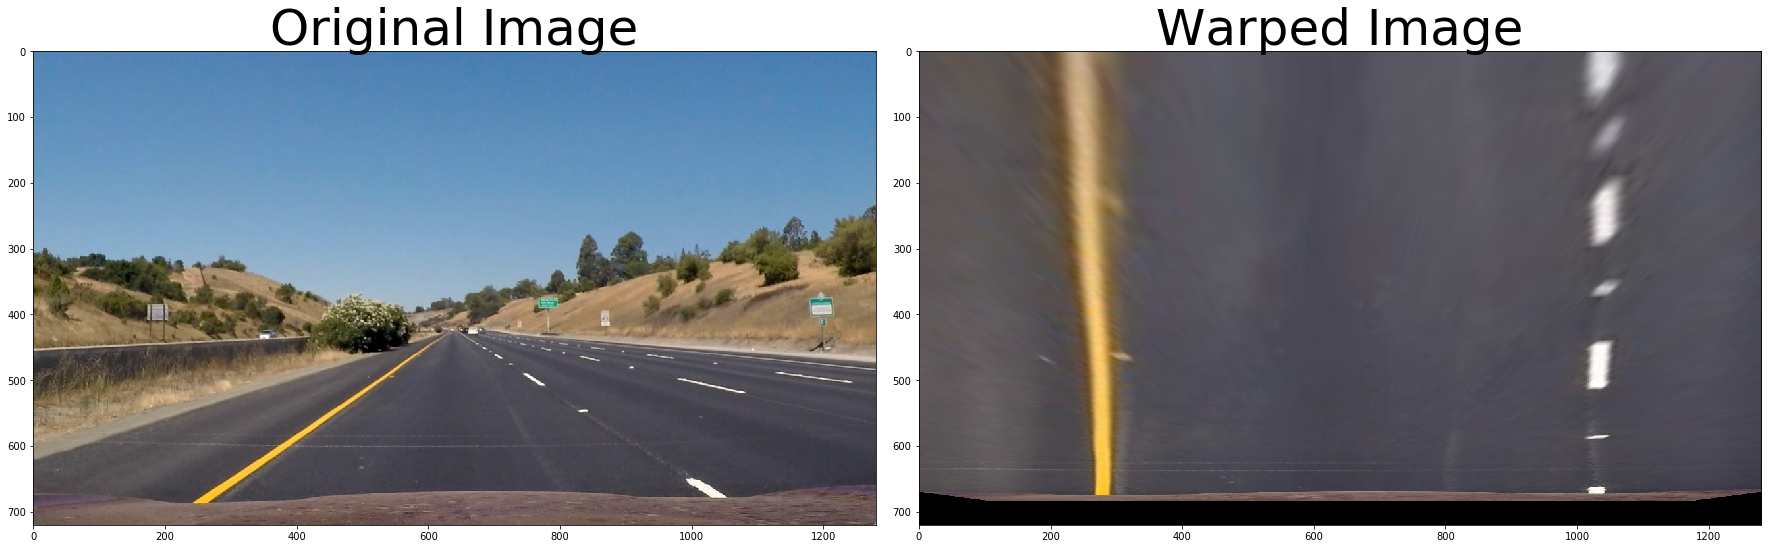

In [8]:
def get_M(mtx, dist):
            
    src = np.float32(
        [[276,669],
         [1031,669],
         [772,506],
         [517,506]]) 
    
    dst = np.float32(
        [[276,669],
         [1031,669],
         [1031,506],
         [276,506]])     
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)    
    #print(M)
    #print(Minv)

    return M, Minv

def unwarp(img, M):
            
    img_size = (img.shape[1],img.shape[0]) 
    unwarped = cv2.warpPerspective(img, M, img_size)    
       
    if False:
        plt.imshow(unwarped)

    return unwarped


img = mpimg.imread('../test_images/straight_lines1.jpg')
undistorted = cal_undistort(img, mtx, dist)
M, Minv = get_M(mtx, dist)
warped = unwarp(img, M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combining all Image Processing methods

Here all the methods as brought together
* Region os interest
* Camera undistortion
* Color threshold
* Grad threshold

The criterion used to obtain the final image is as follows:
  <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ((gradx == 1) & (gradx == 1)) |
  <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ((mag_binary == 1) & (dir_binary == 1))) | 
  <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; (hls_binary==1)
  
Other criterion could have provided better images.

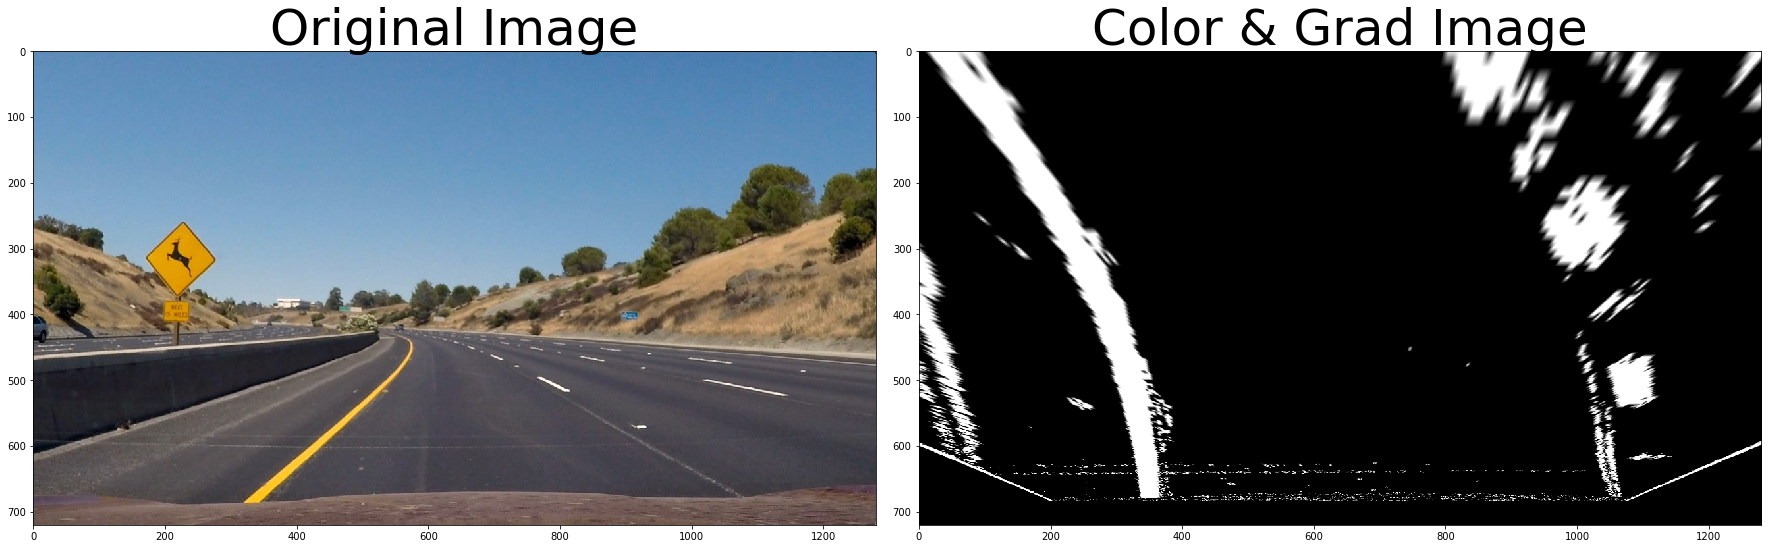

In [9]:
grad_low=10
grad_high=210
hls_binary_low  = 100
hls_binary_high = 255

def grad_and_color(img):
    global grad_low
    global grad_high
    global hls_binary_low
    global hls_binary_high
    
    #Perform Gaussian smoothing  
    kernel_size = 7
    #blur = gaussian_blur(img,kernel_size)   # not helping

    #Mask the edges
    imshape = img.shape
    vertices = np.array([[(0.1*imshape[1],imshape[0]),(0.4*imshape[1], 0.5*imshape[0]), (0.6*imshape[1], 0.5*imshape[0]), (0.9*imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(img, vertices)
           
    undistorted = cal_undistort(masked_edges, mtx, dist)
    gradx = abs_sobel_thresh(undistorted, orient='x',thresh_min=grad_low, thresh_max=grad_high)
    grady = abs_sobel_thresh(undistorted, orient='y',thresh_min=grad_low, thresh_max=grad_high)
    mag_binary = mag_thresh(undistorted, sobel_kernel=5, mag_thresh=(grad_low, grad_high))
    dir_binary = dir_threshold(undistorted, sobel_kernel=5, thresh=(0.7, 1.3))
    hls_binary = hls_select(undistorted, thresh=(hls_binary_low, hls_binary_high))
    
    combined = np.zeros_like(dir_binary)    
    combined[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) | (hls_binary==1)] = 1
               
    binary_warped = unwarp(combined, M)
    
    return binary_warped

img = mpimg.imread('../test_images/test2.jpg')
color_grad = grad_and_color(img)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(color_grad, cmap='gray')
ax2.set_title('Color & Grad Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Find lanes the brure force method

* Calculate histogram (pixle count vs X location) 
* Use the peak value in the histogram to locate the starting (closest to car) points
* Use sliding windows and capture lane (left and right) pixles 
* Fit a 2nd order polynomial through the identified lane pixles 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


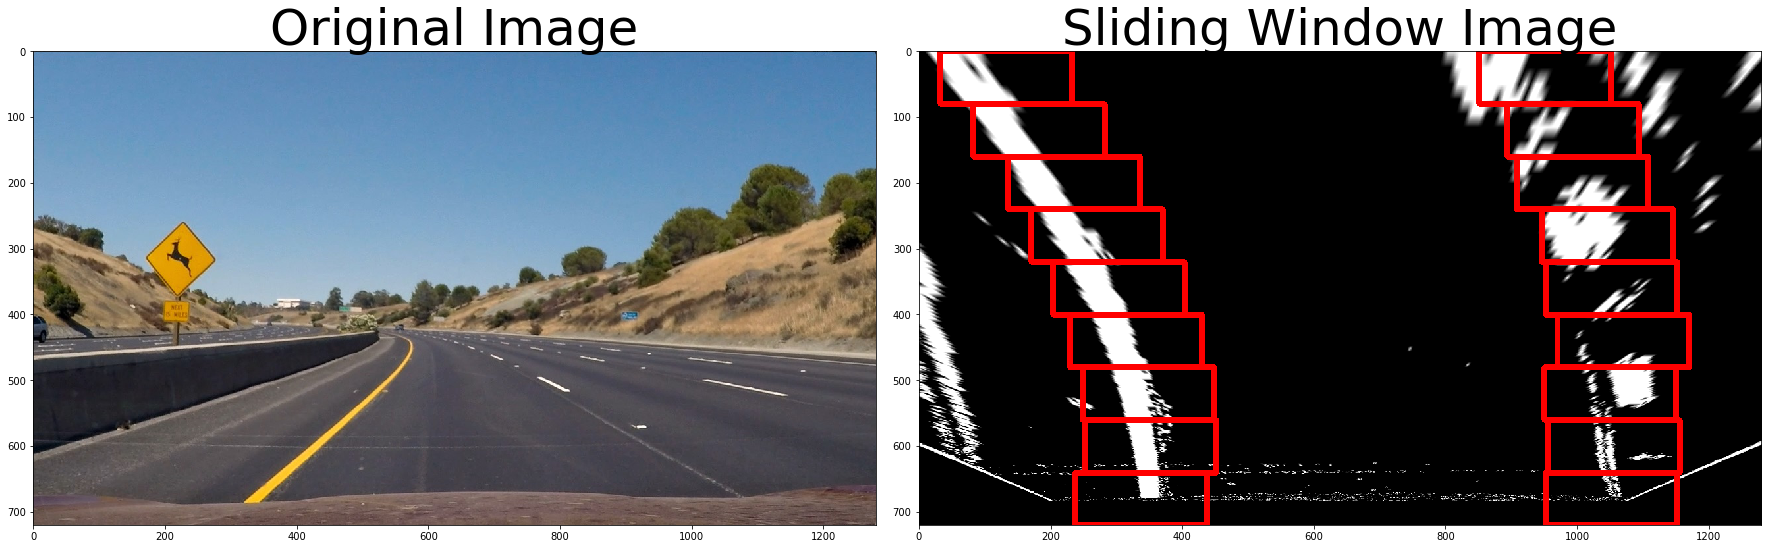

In [10]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(255,0,0), 8) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(255,0,0), 8) 
        
        ###Identify the nonzero pixels in x and y within the window ###
        good_left_inds  = ((nonzerox > win_xleft_low) & (nonzerox < win_xleft_high) & 
                           (nonzeroy > win_y_low) & (nonzeroy<win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox > win_xright_low) & (nonzerox < win_xright_high) & 
                           (nonzeroy > win_y_low) & (nonzeroy<win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))       

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Colors in the left and right lane regions
    #out_img[lefty, leftx] = [255, 0, 0]
    #out_img[righty, rightx] = [0, 0, 255]    
    
    return leftx, lefty, rightx, righty, out_img

def search_image(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    left_fit, right_fit, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    return left_fit, right_fit, ploty

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    #ploty = np.linspace(img_shape[0]/2, img_shape[0]-1, img_shape[0]/2)    

                        
    return left_fit, right_fit, ploty


img = mpimg.imread('../test_images/test2.jpg')
binary_warped = grad_and_color(img)
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(out_img)
ax2.set_title('Sliding Window Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Find lanes around a path from the previous frame

* Narrow down the search around a path (2nd order polynomial) that was identified earlier.  
* Fit a 2nd order polynomial through the identified lane pixles

In [11]:
def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return left_fit, right_fit, ploty

In [12]:
def measure_curvature_and_offset_real(imshape, leftx, lefty, rightx, righty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
            
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = imshape[0]*ym_per_pix

    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    A = left_fit_cr[0]
    B = left_fit_cr[1]
    left_curverad = np.power(1+(2*A*y_eval+B)**2,1.5)/np.abs(2*A)  ## Implement the calculation of the left line here
    A = right_fit_cr[0]
    B = right_fit_cr[1]
    right_curverad = np.power(1+(2*A*y_eval+B)**2,1.5)/np.abs(2*A)   ## Implement the calculation of the right line here        
    
    left_x_bot  = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
    right_x_bot = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2] 
    
    lane_center = (left_x_bot+right_x_bot)/2
    image_center = imshape[1]*xm_per_pix/2
    
    offset = image_center - lane_center
    
    #print("image_center , lane_center",image_center , lane_center)
    
    return left_curverad, right_curverad, offset

In [13]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
left_line = Line()
right_line = Line()

## Pipeline to process images

* Apply gradient and color threshold 
* If this is the first frame then use brute force to detect lanes otherwise search around a previously identified lane path
* Measure curvature and offset
* Calculate ratio of left and righ curvature
* Calculate the mean distance between lanes 
* Calculate the standard deviation of the distance between lanes. 
* To verify if lanes have been detected correctly -
    * curvature ratio is in-between 1/3 and 3
    * mean distance between lanes within 600 and 900 pixles
    * standard deviation of the distance between lanes is less than 50 pixles
* If lanes are detected then use the lane obtined from cheap search (search around poly)
* If lanes are not detected then keep using lanes from previous frame
* If *max_frame_missed* frames are missed then use the lane obtined from brure force

## Performace metrics

The choice of the threshold parameters has a significant impact on the quality of the lane finding process. One option to select the thresholds is to rely on subjective evaluation, which is a manual process and can be time intensive. Alternatively, the threshold selection can be automated by using a DOE/optimization routine. This approach will require using a set of metrics that can be used in a cost function.

The following metrics are tracked for each frame of the video:

* total_frames_captured 
* total_frames_missed 
* total_frames_brute_force
The metric **total_frames_captured** can be later used as a cost function in a sensitivity study, DOE or optimization routine

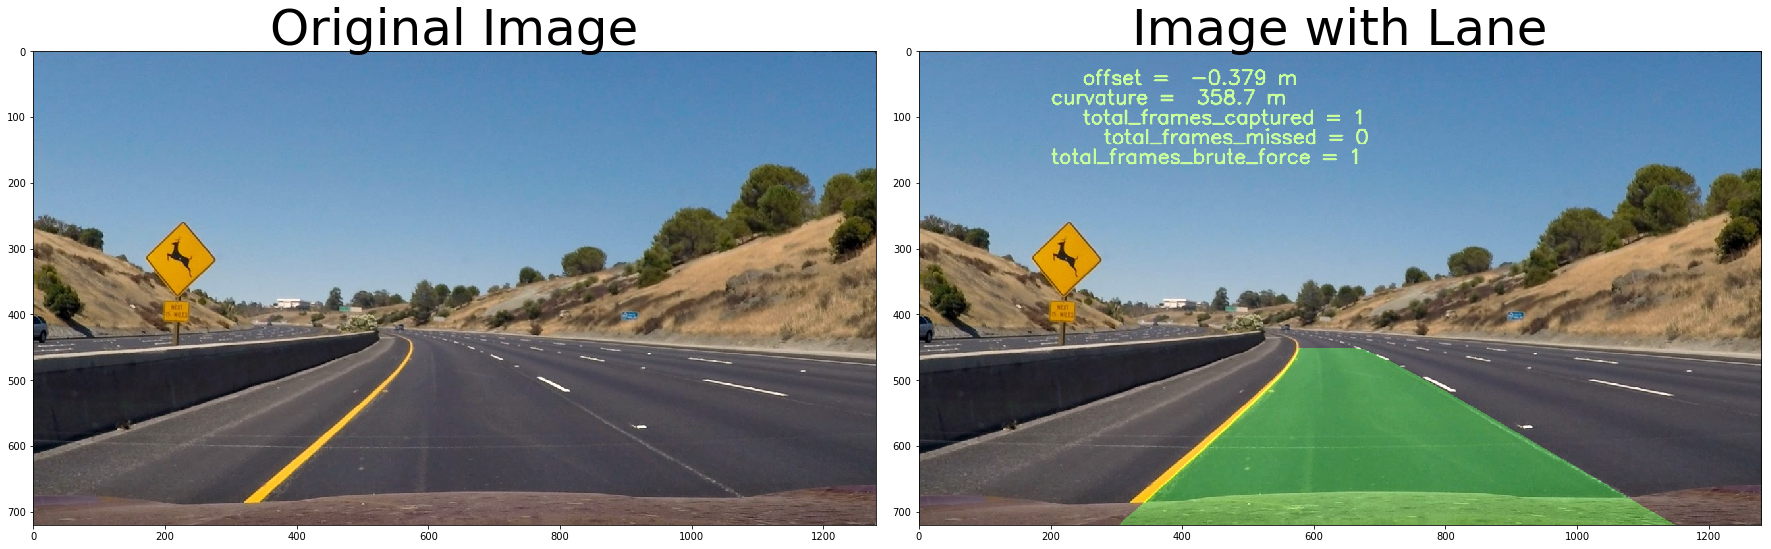

In [14]:
def process_image(img):  
    global n_frame_missed      
    global total_frames_captured 
    global total_frames_missed 
    global total_frames_brute_force 

    #Apply gradient and color threshold
    binary_warped = grad_and_color(img)
    imshape = img.shape
    
    #f this is the first frame then use brute force to detect lanes otherwise search around a previously identified lane path    
    if(right_line.current_fit[0] == False):
        left_fit, right_fit, ploty = search_image(binary_warped)
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit
        total_frames_brute_force = total_frames_brute_force + 1 
    else:
        left_fit, right_fit, ploty = search_around_poly(binary_warped, left_line.current_fit, right_line.current_fit)           
        
    left_fitx  = left_fit[0]*ploty**2  + left_fit[1]*ploty  + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]  

    # Measure curvature and offset  
    # Calculate ratio of left and righ curvature
    left_curverad, right_curverad, offset = measure_curvature_and_offset_real(imshape,left_fitx, ploty, right_fitx, ploty)       
    curverad_mean = (left_curverad+right_curverad)/2
    curverad_ratio = left_curverad/right_curverad

    # Calculate the mean distance between lanes
    # Calculate the standard deviation of the distance between lanes.  
    dist_x_mean = np.mean(right_fitx-left_fitx) #should be around 750 pixles
    dist_x_std = np.std(right_fitx-left_fitx) #should be less than 50 pixles    
    
    #verify if lanes have been detected correctly
    left_line.detected = False
    right_line.detected = False
    if ( (curverad_ratio > 0.33 and curverad_ratio < 3)  and 
         (dist_x_mean > 600 and dist_x_mean < 900)   and
         (dist_x_std < 50)):
           #print('dist_x_mean = ',dist_x_mean, 'dist_x_std = ',dist_x_std, 'curverad_ratio =',curverad_ratio)
           left_line.detected = True
           right_line.detected = True
                      
    # If lanes are detected then use the lane obtined from cheap search (search around poly)
    # If lanes are not detected then keep using lanes from previous frame
    if (left_line.detected == True):
        n_frame_missed = 0 
        total_frames_captured = total_frames_captured + 1
        left_line.current_fit =  ((n_smooth-1)/n_smooth)*left_line.current_fit +  (1/n_smooth)*left_fit
        right_line.current_fit = ((n_smooth-1)/n_smooth)*right_line.current_fit + (1/n_smooth)*right_fit
    else:
        n_frame_missed = n_frame_missed + 1
        total_frames_missed = total_frames_missed + 1
        
    # If max_frame_missed frames are missed then use the lane obtined from brure force    
    if(n_frame_missed == max_frame_missed):
        left_fit, right_fit, ploty  = search_image(binary_warped)  
        left_line.current_fit =  ((n_smooth-1)/n_smooth)*left_line.current_fit +  (1/n_smooth)*left_fit
        right_line.current_fit = ((n_smooth-1)/n_smooth)*right_line.current_fit + (1/n_smooth)*right_fit
        total_frames_brute_force = total_frames_brute_force + 1 
        n_frame_missed = 0         

   # print("n_frame_missed ",n_frame_missed)
             
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    #plt.imshow(warp_zero)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    #print(pts)
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    text_offset   = ("   offset =  {0:.3f} m").format(offset)
    text_cruverad = ("curvature =  {0:.1f} m").format(curverad_mean)            
    text_total_frames_captured    =  ("   total_frames_captured = {}").format(total_frames_captured)
    text_total_frames_missed      =  ("     total_frames_missed = {}").format(total_frames_missed)
    text_total_frames_brute_force =  ("total_frames_brute_force = {}").format(total_frames_brute_force)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,text_offset,(200,50), font, 1, (200,255,155), 2, cv2.LINE_AA)
    cv2.putText(result,text_cruverad,(200,80), font, 1, (200,255,155), 2, cv2.LINE_AA)
    cv2.putText(result,text_total_frames_captured,(200,110), font, 1, (200,255,155), 2, cv2.LINE_AA)
    cv2.putText(result,text_total_frames_missed,(200,140), font, 1, (200,255,155), 2, cv2.LINE_AA) 
    cv2.putText(result,text_total_frames_brute_force,(200,170), font, 1, (200,255,155), 2, cv2.LINE_AA)    
    
    return result

total_frames_captured = 0
total_frames_missed = 0
total_frames_brute_force = 0
img = mpimg.imread('../test_images/test2.jpg')
out_img = process_image(img)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(out_img)
ax2.set_title('Image with Lane', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Optimize lane finding by tuning paremeters

Parameters can be tuned by running sensitivity studies, DOEs or optimization routines.  Shown below is an example of understaning the inflence of the lower bound of S-threshold.  

In [15]:
iter = 0 
hls_binary_high = 255
for hls_binary_low in range(80,110,10):               
    total_frames_captured = 0
    total_frames_missed = 0
    total_frames_brute_force = 0  
    white_output = str(iter) + '_challenge_video_out.mp4'
    clip1 = VideoFileClip("../challenge_video.mp4").subclip(0,2)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    white_clip.write_videofile(white_output, audio=False)
    print("iter low high", iter, hls_binary_low,hls_binary_high)
    print(total_frames_captured,total_frames_missed,total_frames_brute_force)        
    iter=iter+1

Moviepy - Building video 0_challenge_video_out.mp4.
Moviepy - Writing video 0_challenge_video_out.mp4



Moviepy - Done !
Moviepy - video ready 0_challenge_video_out.mp4
iter low high 0 80 255
28 33 4
Moviepy - Building video 1_challenge_video_out.mp4.
Moviepy - Writing video 1_challenge_video_out.mp4



Moviepy - Done !
Moviepy - video ready 1_challenge_video_out.mp4
iter low high 1 90 255
22 39 7
Moviepy - Building video 2_challenge_video_out.mp4.
Moviepy - Writing video 2_challenge_video_out.mp4



Moviepy - Done !
Moviepy - video ready 2_challenge_video_out.mp4
iter low high 2 100 255
0 61 15


## Process video

* Once all the parameters have been tuned the final video can be processed

In [16]:
total_frames_captured = 0
total_frames_missed = 0
total_frames_brute_force = 0  

white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("../project_video.mp4") #.subclip(5,7)

#white_output = 'challenge_video_out.mp4'
#clip1 = VideoFileClip("../challenge_video.mp4") #.subclip(5,7)

#white_output = 'harder_challenge_video_out.mp4'
#clip1 = VideoFileClip("../harder_challenge_video.mp4") #.subclip(5,7)

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video project_video_out.mp4.
Moviepy - Writing video project_video_out.mp4



Moviepy - Done !
Moviepy - video ready project_video_out.mp4


## Project Video
<video controls src="project_video_out.mp4" />

## Challenge Video
<video controls src="challenge_video_out.mp4" />

## Harder Challenge Video
<video controls src="harder_challenge_video_out.mp4" />

## Discussion

**Challenges**

* Tuning the threshold parameters was time consuming and therefore an automated method was implemented. 

* The pipeline did not perform well for the challenge and harder_challenge videos.

**Improvement**

* The criretion used to combine images obtained from color and gradient images could be modified to get better images under various light conditions.

* There are numerous parameters that are used at each stage of the pipeline. The optimization framework can be used to obtain better estiamtes for these parameters.   

* The threshold parameters could be made dynamic i.e. a different set can be changes based on the conditions.

**Drwabacks**

* The pipeline is not robust for every light conditions (e.g shadows) as evident from *challenge_video_out.mp4* and *harder_challenge_video_out.mp4*

* The pipeline won't perform well during lane changing.



